In [7]:
import sys
sys.path.insert(1, '/scratch/cinthiasouza/mv-text-summarizer')

import itertools
import re

import glob, os
import pandas as pd
import json
import spacy
import nltk
import numpy as np
import json
#import smogn
import seaborn as sns
import pickle

from bs4 import BeautifulSoup
from pysbd.utils import PySBDFactory
import math

from sumeval.metrics.rouge import RougeCalculator
rouge = RougeCalculator(stopwords=True, lang="en")
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import matthews_corrcoef
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
#from tensorflow.keras.models import model_from_json

#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
#nltk.download('punkt')
#nltk.download('stopwords')

#!python -m spacy download en_core_web_sm
nlp_sm = spacy.load('en_core_web_sm')

#import en_core_web_sm
#nlp_md = en_core_web_sm.load()y

#import en_core_web_md
#nlp_md = en_core_web_md.load()
#!python -m spacy download en_core_web_md
nlp_md = spacy.load('en_core_web_md')

import warnings
warnings.filterwarnings("ignore")

path_base = "/scratch/cinthiasouza/mv-text-summarizer"


In [8]:
%load_ext autoreload
%autoreload 2

from src import preprocess
from src import extract_features
from src import tokenizer
from src import create_features_df
from src import transform_data
from src import loader
from src import utils
from src import ensemble_tree_models
from src import tunning_hyperparametrs as th
#from src import mlp_regressor
#from src import mlp_classifier
from src import summarization
from src import normalization
from src import ensemble_tree_models as classifiers
from src import utils_classification as utils_clf
from src import evaluate_classifiers as ev
from src import prepare_data
from src import display_results as dr
import joblib
from joblib import Parallel, delayed
#from tensorflow.keras.utils import to_categorical
from src import pipeline_extract_features as pef

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Features

In [ ]:
len(pd.unique(features_intro['articles']))

In [181]:
#import random

#features_intro, scores_intro = loader.read_features(path="../result/introduction/features_*.csv")
#features_mat, scores_mat = loader.read_features(path="../result/materials/features_*.csv")
#features_conc, scores_conc = loader.read_features(path="../result/conclusion/features_*.csv")

#intro = pd.unique(features_intro['articles'])
#mat = pd.unique(features_mat['articles'])
#conc = pd.unique(features_conc['articles'])

#comuns = list((set(intro) & set(mat)) & set(conc))

#valid_len = int(len(comuns)*0.2)
#summ_items = random.sample(comuns, valid_len)

#df = pd.DataFrame({'summ': summ_items})
#df.to_csv("indices_summ.csv", index=False)

In [144]:
def main(path='.', format_dataset=True, verbose=True):
    
    columns_name = ['text_rank', 'lex_rank', 'count_one_gram',
        'count_article_keywords', 'tf-isf', 'position_score', 'paragraph_score',
       'length_score', 'pos_score', 'ner_score', 'dist_centroid']

    sections=['introduction', 'materials', 'conclusion', 'concat']
    #sections=[ 'introduction']

    if format_dataset:
        if verbose:
            print("Preparando dataset para os classificadores")
        dataset = prepare_data.main_create_dataset(columns_name, sections)
        #utils.save_json(dataset, name='dataset', path=path)
    else:
        if verbose:
            print("Carregando dataset")
        dataset = utils.load_json(name='dataset', path=path)
    
    if verbose:
        print("Treinamento dos modelos")
        
    with open('dataset2.p', 'wb') as fp:
        pickle.dump(dataset, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    return dataset
    
    '''models = ensemble_tree_models.create_models(dataset, sections, name_models=['knn', 'gb', 'rf', 'ab'])
    predictions, results = ev.create_reports(models, dataset, columns_name, verbose=False)
    
    #utils.save_json(predictions, name='prediction', path=path)
    #utils.save_results(results, path=path)
    
    parameters = {'introduction': [0.2, 100, 64],
             'materials': [0.2, 100, 64],
             'conclusion':[0.2, 100, 64],
             'concat': [0.2, 100, 64]}

    models_nn = mlp_classifiers.main_train_nn(dataset, sections, parameters, train=True, verbose=False)
    predictions, results =  mlp_classifiers.eval_nn(dataset, sections)'''
    

In [ ]:
if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('--path', "-p",required=True)
    parser.add_argument('--format_dataset', "-f",required=True)
     
    args = parser.parse_args()

    columns_name = ['text_rank', 'lex_rank', 'count_one_gram',
        'count_article_keywords',
       'tf-isf', 'position_score', 'paragraph_score',
       'length_score', 'pos_score', 'ner_score', 'dist_centroid']

    sections=['introduction', 'materials', 'conclusion', 'concat']

In [145]:
dataset = main(verbose=True)

Preparando dataset para os classificadores
Treinamento dos modelos


In [146]:
dataset['introduction'][0].shape

(70942, 11)

In [9]:
with open('dataset2.p', 'rb') as fp:
    dataset = pickle.load(fp)

In [10]:
columns_name = ['text_rank', 'lex_rank', 'count_one_gram',
        'count_article_keywords',
       'tf-isf', 'position_score', 'paragraph_score',
       'length_score', 'pos_score', 'ner_score', 'dist_centroid']

sections=['introduction', 'materials', 'conclusion', 'concat']

In [140]:
dataset['introduction'][0].shape

(70942, 11)

In [52]:
parameters['materials']['gb']

{'n_estimators': [50, 100, 200, 300],
 'min_samples_leaf': [200, 300, 2500, 5000, 10000],
 'min_samples_split': [400, 600, 2500, 10000, 20000, 30000],
 'max_depth': [20, 10, 50],
 'class_weight': [{0: 0.95, 1: 0.05}]}

In [81]:
dataset['conclusion'][0].shape

(37820, 11)

## Randomized Search -  CV 5 Folds

In [130]:
parameters = {
    
'introduction': {'gb': {'n_estimators': [50, 100, 300],
              'min_samples_leaf':[25, 50, 150],
              'min_samples_split':[50, 100],
              'max_depth':[20, 10, 50],
              'class_weight': [{0:0.98, 1: 0.05}]
              },
              'knn':  {'n_neighbors': [3,  5, 10]},
              'ab': {'n_estimators': [50,  100, 200]},
              'svm': {'kernel': ('poly', 'rbf'), 'degree':[2, 3, 4], 'class_weight': [{0:0.90, 1: 0.1}]}
                 },

"materials": {'gb': {'n_estimators': [50, 100, 200, 300],
              'min_samples_leaf':[200, 300, 2500, 5000, 10000],
              'min_samples_split':[400, 600, 2500, 10000, 20000, 30000],
              'max_depth':[20, 10, 50],
              'class_weight': [{0:0.95, 1: 0.05}]
              },
              'knn':  {'n_neighbors': [3,  5, 10]},
              'ab': {'n_estimators': [50,  100, 200]},
              'svm': {'kernel': ('poly', 'rbf'), 'degree':[2, 3, 4], 'class_weight': [{0:0.95, 1: 0.05}]}
                 },

'conclusion': {'gb': {'n_estimators': [50, 100, 200, 300, 500],
              'min_samples_leaf':[500, 2500],
              'min_samples_split':[ 1000, 5000],
              'max_depth':[20, 10, 50],
              'class_weight': [{0:0.95, 1: 0.05}]
              },
              'knn':  {'n_neighbors': [3,  5, 10]},
              'ab': {'n_estimators': [50,  100, 200]},
              'svm': {'kernel': ('poly', 'rbf'), 'degree':[2, 3, 4], 'class_weight': [{0:0.92, 1: 0.08}]}
                 }
    }

In [56]:
def get_parameters(dataset, name_models, all_parameters, sections):
    
    for name_model in name_models:
        
        for section in sections:

            if name_model == 'knn':
                parameters = all_parameters[section]['knn']
            elif name_model == 'ab':
                parameters = all_parameters[section]['ab'],
            elif name_model == 'svm':
                parameters = all_parameters[section]['svm'],
            else:
                parameters = all_parameters[section]['gb']
                
            
 
            search = ensemble_tree_models.pipeline(dataset, name_model=name_model, section=section, parameters=parameters)
      

In [23]:
from multiprocessing import Process, Queue

name_models = ['knn', 'ab', 'rf', 'gb']
sections = ['introduction', 'materials', 'conclusion', 'concat']

l1 = Queue()
p1 = Process(
    target=get_parameters, args=(
         dataset, ['knn'], all_parameters, sections))

l2 = Queue()
p2 = Process(
    target=get_parameters, args=(
         dataset, ['ab'], all_parameters, sections))


l3 = Queue()
p3 = Process(
    target=get_parameters, args=(
         dataset, ['rf'], all_parameters, sections))


l4 = Queue()
p4 = Process(
    target=get_parameters, args=(
         dataset, ['gb'], all_parameters, sections))

p4.start()
p3.start()
p2.start()  
p1.start()   

/scratch/cinthiasouza/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/backend/resource_tracker.py:318: UserWarning: resource_tracker: There appear to be 200 leaked folder objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/scratch/cinthiasouza/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/backend/resource_tracker.py:318: UserWarning: resource_tracker: There appear to be 60 leaked folder objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


In [131]:
from multiprocessing import Process, Queue

name_models = ['knn', 'ab', 'rf', 'gb']
sections = ['introduction']


l3 = Queue()
p3 = Process(
    target=get_parameters, args=(
         dataset, ['rf'], parameters, sections))


p3.start()
 

In [14]:
def load_rs_model(name_model, sections, path_to_read):
    
    rs_models = {}
    
    for section in sections:
        
        rs_models[section] = joblib.load('{}/search_{}_{}.pkl'.format(path_to_read, name_model, section))
        
    return rs_models

In [15]:
def  get_scores(name_models, sections, path_to_read):

    results = {}
    
    for name_model in name_models:
        
        rs_models = load_rs_model(name_model, sections, path_to_read)
    
        aux  = { 'score_{}'.format(section): rs_models[section].best_score_ for section in sections}
        results[name_model] = aux
        
    return results

In [16]:
path_to_save = '/scratch/cinthiasouza/mv-text-summarizer/notebook/models'

In [137]:
sections=['introduction', 'materials', 'conclusion', 'concat']
name_models = ['knn', 'rf', 'ab', 'gb']

results = get_scores(name_models, sections, path_to_save)

## Results K-Fold Cross Validation

In [138]:
cv_results = pd.DataFrame(results).T
cv_results

,score_introduction,score_materials,score_conclusion,score_concat
knn,0.682832,0.742029,0.734957,0.705928
rf,0.985658,0.996656,0.981871,0.991313
ab,0.690019,0.743808,0.738801,0.708963
gb,0.693036,0.742079,0.735714,0.711943


## Hyperparameters

### KNN

In [22]:
knnsearch = load_rs_model('knn', sections, path_to_save)

for section in sections:
    print("Section: {}".format(section))
    print("Num neighbors: {}\n".format(knnsearch[section].best_estimator_.n_neighbors))

Section: introduction
Num neighbors: 10

Section: materials
Num neighbors: 10

Section: conclusion
Num neighbors: 10

Section: concat
Num neighbors: 10



### AdaBoost

In [23]:
absearch = load_rs_model('ab', sections, path_to_save)

for section in sections:
    print("Section: {}".format(section))
    print("Num estimators: {}\n".format(absearch[section].best_estimator_.n_estimators))

Section: introduction
Num estimators: 200

Section: materials
Num estimators: 200

Section: conclusion
Num estimators: 100

Section: concat
Num estimators: 200



### RF

In [139]:
rfsearch = load_rs_model('rf', sections, path_to_save)

for section in sections:
    print("Section: {}".format(section))
    print("Num estimators: {}".format(rfsearch[section].best_estimator_.n_estimators))
    print("Min samples leaf: {}".format(rfsearch[section].best_estimator_.min_samples_leaf))
    print("Min samples splot: {}".format(rfsearch[section].best_estimator_.min_samples_split))
    print("Max depth: {}\n".format(rfsearch[section].best_estimator_.max_depth))

Section: introduction
Num estimators: 50
Min samples leaf: 150
Min samples splot: 50
Max depth: 50

Section: materials
Num estimators: 100
Min samples leaf: 200
Min samples splot: 20000
Max depth: 20

Section: conclusion
Num estimators: 50
Min samples leaf: 500
Min samples splot: 1000
Max depth: 50

Section: concat
Num estimators: 50
Min samples leaf: 300
Min samples splot: 600
Max depth: 50



### GB

In [24]:
gbsearch = load_rs_model('gb', sections, path_to_save)

for section in sections:
    print("Section: {}".format(section))
    print("Num estimators: {}".format(gbsearch[section].best_estimator_.n_estimators))
    print("Min samples leaf: {}".format(gbsearch[section].best_estimator_.min_samples_leaf))
    print("Min samples splot: {}".format(gbsearch[section].best_estimator_.min_samples_split))
    print("Max depth: {}\n".format(gbsearch[section].best_estimator_.max_depth))


Section: introduction
Num estimators: 100
Min samples leaf: 5
Min samples splot: 40
Max depth: 5

Section: materials
Num estimators: 100
Min samples leaf: 5
Min samples splot: 40
Max depth: 5

Section: conclusion
Num estimators: 100
Min samples leaf: 5
Min samples splot: 40
Max depth: 5

Section: concat
Num estimators: 200
Min samples leaf: 20
Min samples splot: 10
Max depth: 5



## Train Test

In [141]:
parameters = {
    'gb' : {
        'introduction': {'n_estimators': gbsearch['introduction'].best_estimator_.n_estimators,
              'min_samples_leaf':gbsearch['introduction'].best_estimator_.min_samples_leaf,
              'min_samples_split':gbsearch['introduction'].best_estimator_.min_samples_split,
              'max_depth':gbsearch['introduction'].best_estimator_.max_depth},
        'materials': {'n_estimators': gbsearch['materials'].best_estimator_.n_estimators,
              'min_samples_leaf':gbsearch['materials'].best_estimator_.min_samples_leaf,
              'min_samples_split':gbsearch['materials'].best_estimator_.min_samples_split,
              'max_depth':gbsearch['materials'].best_estimator_.max_depth},
        'conclusion': {'n_estimators': gbsearch['conclusion'].best_estimator_.n_estimators,
              'min_samples_leaf':gbsearch['conclusion'].best_estimator_.min_samples_leaf,
              'min_samples_split':gbsearch['conclusion'].best_estimator_.min_samples_split,
              'max_depth': gbsearch['conclusion'].best_estimator_.max_depth},
        'concat': {'n_estimators': gbsearch['conclusion'].best_estimator_.n_estimators,
              'min_samples_leaf':gbsearch['conclusion'].best_estimator_.min_samples_leaf,
              'min_samples_split':gbsearch['conclusion'].best_estimator_.min_samples_split,
              'max_depth': gbsearch['conclusion'].best_estimator_.max_depth}
    },
    'rf' : {
        'introduction': {'n_estimators': rfsearch['introduction'].best_estimator_.n_estimators,
              'min_samples_leaf':rfsearch['introduction'].best_estimator_.min_samples_leaf,
              'min_samples_split':rfsearch['introduction'].best_estimator_.min_samples_split,
              'max_depth':rfsearch['introduction'].best_estimator_.max_depth,
              'class_weight': rfsearch['introduction'].best_estimator_.class_weight},
        'materials': {'n_estimators': rfsearch['materials'].best_estimator_.n_estimators,
              'min_samples_leaf':rfsearch['materials'].best_estimator_.min_samples_leaf,
              'min_samples_split':rfsearch['materials'].best_estimator_.min_samples_split,
              'max_depth':rfsearch['materials'].best_estimator_.max_depth,
              'class_weight': rfsearch['materials'].best_estimator_.class_weight},
        'conclusion': {'n_estimators': rfsearch['conclusion'].best_estimator_.n_estimators,
              'min_samples_leaf':rfsearch['conclusion'].best_estimator_.min_samples_leaf,
              'min_samples_split':rfsearch['conclusion'].best_estimator_.min_samples_split,
              'max_depth': rfsearch['conclusion'].best_estimator_.max_depth,
              'class_weight': rfsearch['conclusion'].best_estimator_.class_weight},
        'concat': {'n_estimators': rfsearch['conclusion'].best_estimator_.n_estimators,
              'min_samples_leaf':rfsearch['conclusion'].best_estimator_.min_samples_leaf,
              'min_samples_split':rfsearch['conclusion'].best_estimator_.min_samples_split,
              'max_depth': rfsearch['conclusion'].best_estimator_.max_depth,
              'class_weight': rfsearch['conclusion'].best_estimator_.class_weight}
    },
    'ab' : {
        'introduction': {'n_estimators': absearch['introduction'].best_estimator_.n_estimators},
        'materials': {'n_estimators': absearch['materials'].best_estimator_.n_estimators},
        'conclusion': {'n_estimators': absearch['conclusion'].best_estimator_.n_estimators},
        'concat': {'n_estimators': absearch['conclusion'].best_estimator_.n_estimators}
    },
    'knn': {
        'introduction': {'n_neighbors': knnsearch['introduction'].best_estimator_.n_neighbors},
        'materials': {'n_neighbors': knnsearch['materials'].best_estimator_.n_neighbors},
        'conclusion': {'n_neighbors': knnsearch['conclusion'].best_estimator_.n_neighbors},
        'concat': {'n_neighbors': knnsearch['conclusion'].best_estimator_.n_neighbors}
    },
    'mlp': {
        'introduction': {'hidden_layer_sizes': (128,256,256, 128,), 'activation': 'relu', 'max_iter':300, 'batch_size':64},
        'materials': {'hidden_layer_sizes': (128,256,128,), 'activation': 'relu', 'max_iter':300, 'batch_size': 64},
        'conclusion': {'hidden_layer_sizes': (128,256,128,), 'activation': 'relu', 'max_iter':300, 'batch_size': 64},
        'concat': {'hidden_layer_sizes': (128,256,128,200,), 'activation': 'relu', 'max_iter':300, 'batch_size': 64},
    }

}

In [41]:
from multiprocessing import Process, Queue

sections=['introduction', 'materials', 'conclusion', 'concat']
name_models = ['knn', 'rf', 'ab', 'mlp']

l1 = Queue()
p1 = Process(
    target=classifiers.create_models, args=(
         dataset, parameters, sections, ['knn']))

l2 = Queue()
p2 = Process(
    target=classifiers.create_models, args=(
         dataset, parameters, sections, ['ab']))

l3 = Queue()
p3 = Process(
    target=classifiers.create_models, args=(
         dataset, parameters, sections, ['rf']))

l4 = Queue()
p4 = Process(
    target=classifiers.create_models, args=(
         dataset, parameters, sections, ['gb']))

l5 = Queue()
p5 = Process(
    target=classifiers.create_models, args=(
         dataset, parameters, sections, ['mlp']))

p1.start()   
p2.start()   
p3.start()   
p4.start()   
p5.start()   

In [142]:
from multiprocessing import Process, Queue

sections=['introduction']
name_models = ['knn', 'rf', 'ab', 'mlp']


l3 = Queue()
p3 = Process(
    target=classifiers.create_models, args=(
         dataset, parameters, sections, ['rf']))


p3.start()   
 

In [115]:
def load_classifiers(sections, path_to_read, name_models):

    models = {}
    
    for section in sections:
        
        aux = {}
        
        for name_model in name_models:
            aux[name_model] = joblib.load('{}/{}_{}.pkl'.format(path_to_read, name_model,  section))
            
        models[section] = aux
        
    return models

In [116]:
path_to_save = '/scratch/cinthiasouza/mv-text-summarizer/notebook/models'

sections=['introduction', 'materials', 'conclusion']
name_models = ['knn', 'rf', 'ab', 'gb', 'mlp']

models = load_classifiers(sections, path_to_save, name_models)

In [117]:
predictions, predictions_proba, results = ev.create_reports(models, dataset, columns_name, name_models, verbose=False)

In [129]:
sum(predictions['introduction']['rf'])

11

In [91]:
dr.display_results(results, section='introduction')

,model,precision,recall,f1-score,support
0,knn,0.911730,0.686747,0.783405,4482.000000
1,knn,0.280738,0.647754,0.391708,846.000000
accuracy,knn,0.680556,0.680556,0.680556,0.680556
macro avg,knn,0.596234,0.667251,0.587557,5328.000000
weighted avg,knn,0.811539,0.680556,0.721210,5328.000000
,model,precision,recall,f1-score,support
0,ab,0.927476,0.647702,0.762743,4482.000000
1,ab,0.281620,0.731678,0.406702,846.000000
accuracy,ab,0.661036,0.661036,0.661036,0.661036
macro avg,ab,0.604548,0.689690,0.584722,5328.000000


,model,precision,recall,f1-score,support
0,rf,0.842392,0.999331,0.914175,4482.000000
1,rf,0.727273,0.009456,0.018670,846.000000
accuracy,rf,0.842155,0.842155,0.842155,0.842155
macro avg,rf,0.784833,0.504393,0.466422,5328.000000
weighted avg,rf,0.824113,0.842155,0.771983,5328.000000
,model,precision,recall,f1-score,support
0,gb,0.928594,0.644132,0.760638,4482.000000
1,gb,0.281208,0.737589,0.407178,846.000000
accuracy,gb,0.658971,0.658971,0.658971,0.658971
macro avg,gb,0.604901,0.690860,0.583908,5328.000000


,model,precision,recall,f1-score,support
0,mlp,0.922287,0.601071,0.727813,4482.000000
1,mlp,0.257167,0.731678,0.380572,846.000000
accuracy,mlp,0.621809,0.621809,0.621809,0.621809
macro avg,mlp,0.589727,0.666375,0.554192,5328.000000
weighted avg,mlp,0.816677,0.621809,0.672677,5328.000000


In [75]:
dr.display_results(results, section='materials')

,model,precision,recall,f1-score,support
0,knn,0.931785,0.806243,0.864480,5574.000000
1,knn,0.284294,0.565963,0.378474,758.000000
accuracy,knn,0.777479,0.777479,0.777479,0.777479
macro avg,knn,0.608040,0.686103,0.621477,6332.000000
weighted avg,knn,0.854274,0.777479,0.806301,6332.000000
,model,precision,recall,f1-score,support
0,ab,0.944877,0.784177,0.857059,5574.000000
1,ab,0.294842,0.663588,0.408279,758.000000
accuracy,ab,0.769741,0.769741,0.769741,0.769741
macro avg,ab,0.619859,0.723882,0.632669,6332.000000


,model,precision,recall,f1-score,support
0,rf,0.890363,0.999462,0.941763,5574.000000
1,rf,0.960000,0.094987,0.172869,758.000000
accuracy,rf,0.891188,0.891188,0.891188,0.891188
macro avg,rf,0.925181,0.547224,0.557316,6332.000000
weighted avg,rf,0.898699,0.891188,0.849719,6332.000000
,model,precision,recall,f1-score,support
0,gb,0.949056,0.775386,0.853476,5574.000000
1,gb,0.295838,0.693931,0.414826,758.000000
accuracy,gb,0.765635,0.765635,0.765635,0.765635
macro avg,gb,0.622447,0.734659,0.634151,6332.000000


,model,precision,recall,f1-score,support
0,mlp,0.931939,0.847506,0.887720,5574.000000
1,mlp,0.326999,0.544855,0.408709,758.000000
accuracy,mlp,0.811276,0.811276,0.811276,0.811276
macro avg,mlp,0.629469,0.696181,0.648214,6332.000000
weighted avg,mlp,0.859522,0.811276,0.830377,6332.000000


In [76]:
dr.display_results(results, section='conclusion')

,model,precision,recall,f1-score,support
0,knn,0.957848,0.788392,0.864898,10751.000000
1,knn,0.167277,0.550602,0.256597,830.000000
accuracy,knn,0.771350,0.771350,0.771350,0.771350
macro avg,knn,0.562563,0.669497,0.560748,11581.000000
weighted avg,knn,0.901189,0.771350,0.821302,11581.000000
,model,precision,recall,f1-score,support
0,ab,0.963224,0.750349,0.843564,10751.000000
1,ab,0.162820,0.628916,0.258672,830.000000
accuracy,ab,0.741646,0.741646,0.741646,0.741646
macro avg,ab,0.563022,0.689632,0.551118,11581.000000


,model,precision,recall,f1-score,support
0,rf,0.931444,0.999628,0.964332,10751.000000
1,rf,0.906977,0.046988,0.089347,830.000000
accuracy,rf,0.931353,0.931353,0.931353,0.931353
macro avg,rf,0.919210,0.523308,0.526840,11581.000000
weighted avg,rf,0.929690,0.931353,0.901623,11581.000000
,model,precision,recall,f1-score,support
0,gb,0.965276,0.744675,0.840746,10751.000000
1,gb,0.164892,0.653012,0.263299,830.000000
accuracy,gb,0.738106,0.738106,0.738106,0.738106
macro avg,gb,0.565084,0.698843,0.552022,11581.000000


,model,precision,recall,f1-score,support
0,mlp,0.956782,0.654823,0.777514,10751.000000
1,mlp,0.121241,0.616867,0.202652,830.000000
accuracy,mlp,0.652103,0.652103,0.652103,0.652103
macro avg,mlp,0.539011,0.635845,0.490083,11581.000000
weighted avg,mlp,0.896899,0.652103,0.736314,11581.000000


# Matthews Correlation

In [61]:
df = ev.matthews(sections, dataset, predictions, name_models)
df

,introduction,materials,conclusion
knn,0.253733,0.283595,0.205953
rf,0.069668,0.312570,0.203416
ab,0.281650,0.327624,0.218641
gb,0.282994,0.339017,0.227522
mlp,0.244363,0.318743,0.145595


# ROC

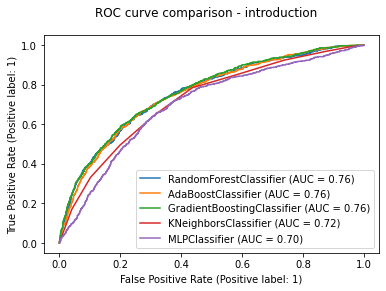

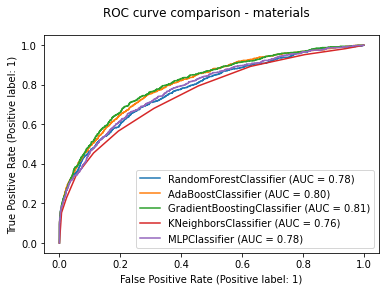

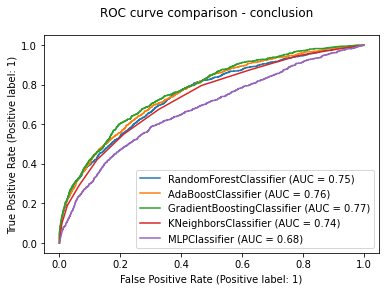

In [71]:
ev.roc_curve(sections, dataset, models)

In [91]:
import numpy as np
from sklearn.ensemble import VotingClassifier

from sklearn.tree import DecisionTreeClassifier

n_estimators = 300
estimators = []

for i in range(300):
    
    rf =  DecisionTreeClassifier(
        max_depth=10, splitter='best', min_samples_split=200,
        min_samples_leaf= 100, class_weight={0:0.98,1:0.02})
    
    estimators.append(('rf_' + str(i), rf))


model = VotingClassifier(estimators, voting='hard')
model = model.fit(dataset['introduction'][0], dataset['introduction'][2])
predictions = model.predict(dataset['introduction'][1])


In [105]:
sum(predictions)

TypeError: unsupported operand type(s) for +: 'int' and 'str'